# Cleaning data

## Robust data cleaning!

### 1. **Better Type Handling**
- Uses `Int64` (nullable integer) instead of to preserve NaN values `int`
- Uses `float64` for decimal precision
- Properly handles data type conversions

### 2. **Comprehensive Data Cleaning**
- Handles multiple decimal points
- Removes currency symbols (€, $, £, etc.)
- Handles European number formats (1.234.567,89)
- Removes units (m², sqm, etc.)
- Handles various null representations

### 3. **Data Validation**
- Min/max value constraints
- Negative value handling
- Outlier detection using IQR method
- Comprehensive reporting

### 4. **Better Error Handling**
- Checks if columns exist
- Reports invalid data conversions
- Provides detailed statistics

### 5. **Production-Ready Features**
- Proper documentation
- Progress indicators
- Data quality checks
- Validation summary
- File size reporting

In [1]:
import pandas as pd
import numpy as np
import re

# ENHANCED HELPER FUNCTIONS
def clean_numeric_column(df, column, as_int=False, is_price=False, is_percentage=False,
                         allow_negative=False, min_value=None, max_value=None):
    """
    Clean and standardize numeric columns with comprehensive data validation.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing the column to clean
    column : str
        Name of the column to clean
    as_int : bool
        Convert to integer type (default: False, keeps as float)
    is_price : bool
        Special handling for price/currency formats (default: False)
    is_percentage : bool
        Special handling for percentage values (default: False)
    allow_negative : bool
        Whether to allow negative values (default: False)
    min_value : float or None
        Minimum acceptable value, values below are set to NaN
    max_value : float or None
        Maximum acceptable value, values above are set to NaN

    Returns:
    --------
    pandas.DataFrame
        DataFrame with cleaned numeric column
    """

    if column not in df.columns:
        print(f"Warning: Column '{column}' not found in dataframe")
        return df

    # Store original non-null count for reporting
    original_non_null = df[column].notna().sum()

    # Create a copy to avoid SettingWithCopyWarning
    cleaned_series = df[column].copy()

    # Convert to string for cleaning, preserve NaN
    cleaned_series = cleaned_series.astype(str)

    # Replace common null representations
    null_patterns = ['nan', 'none', 'null', 'n/a', 'na', '#n/a', '#value!', '#ref!',
                     '<na>', 'missing', 'MISSING', '--', '']
    cleaned_series = cleaned_series.replace(null_patterns, np.nan, regex=False)

    # deal with multiple empty spaces
    cleaned_series = cleaned_series.str.strip()
    cleaned_series.replace('', np.nan, inplace=True)

    # Skip if all values are NaN
    if cleaned_series.isna().all():
        df[column] = np.nan
        print(f"  Warning: Column '{column}' contains only null values")
        return df

    # Handle percentage values
    if is_percentage:
        # Convert percentages like "85%", "85 %", "0.85" to decimal
        cleaned_series = cleaned_series.str.replace(r'\s*%\s*', '', regex=True)
        # Check if values are in percentage format (>1) or decimal format (<=1)
        temp_numeric = pd.to_numeric(cleaned_series, errors='coerce')
        # If most non-null values are > 1, assume they're percentages
        if (temp_numeric > 1).sum() > (temp_numeric <= 1).sum():
            temp_numeric = temp_numeric / 100
        cleaned_series = temp_numeric

    # Handle price/currency values
    elif is_price:
        # Remove currency symbols: €, $, £, ¥, CHF, USD, EUR, etc.
        cleaned_series = cleaned_series.str.replace(r'[€$£¥₹₽¢]', '', regex=True)
        cleaned_series = cleaned_series.str.replace(r'\b(USD|EUR|GBP|CHF|CAD|AUD|JPY)\b', '',
                                                   regex=True, flags=re.IGNORECASE)

        # Handle European number format: 1.234.567,89 -> 1234567.89
        # First, remove thousand separators (dots, spaces, apostrophes)
        cleaned_series = cleaned_series.str.replace(r'(?<=\d)[.\s\'\u202f\u00a0]+(?=\d{3})', '', regex=True)

        # Convert decimal comma to dot: 123,45 -> 123.45
        # But only if it's the last comma (to avoid issues with thousand separators)
        cleaned_series = cleaned_series.str.replace(r',(\d{1,2})$', r'.\1', regex=True)

        # Remove any remaining non-numeric characters except decimal point and minus
        cleaned_series = cleaned_series.str.replace(r'[^\d.\-]', '', regex=True)

    # Handle regular numeric values (areas, counts, etc.)
    else:
        # Remove units like m², m2, sqm, sq.m, cm, km, etc.
        cleaned_series = cleaned_series.str.replace(r'\s*(m[²2]|sqm?|sq\.?\s*m|cm|km|ft²?|square\s*meters?)\s*',
                                                   '', regex=True, flags=re.IGNORECASE)

        # Remove thousand separators and normalize decimal separators
        cleaned_series = cleaned_series.str.replace(r'(?<=\d)[.\s\'\u202f\u00a0]+(?=\d{3})', '', regex=True)
        cleaned_series = cleaned_series.str.replace(',', '.', regex=False)

        # Remove any remaining non-numeric characters except decimal point and minus
        cleaned_series = cleaned_series.str.replace(r'[^\d.\-]', '', regex=True)

    # Handle multiple decimal points (keep only the last one)
    def fix_multiple_decimals(val):
        if pd.isna(val) or val == '':
            return np.nan
        if isinstance(val, str) and val.count('.') > 1:
            parts = val.rsplit('.', 1)  # Split at the last decimal point
            return parts[0].replace('.', '') + '.' + parts[1]
        return val

    cleaned_series = cleaned_series.apply(fix_multiple_decimals)

    # Convert to numeric, coercing errors to NaN
    cleaned_series = pd.to_numeric(cleaned_series, errors='coerce')

    # Handle negative values
    if not allow_negative:
        negative_count = (cleaned_series < 0).sum()
        if negative_count > 0:
            print(f"  Warning: Found {negative_count} negative values in '{column}', setting to NaN")
        cleaned_series = cleaned_series.where(cleaned_series >= 0, np.nan)

    # Apply min/max value constraints
    if min_value is not None:
        out_of_range = (cleaned_series < min_value).sum()
        if out_of_range > 0:
            print(f"  Warning: Found {out_of_range} values below minimum ({min_value}) in '{column}'")
        cleaned_series = cleaned_series.where(cleaned_series >= min_value, np.nan)

    if max_value is not None:
        out_of_range = (cleaned_series > max_value).sum()
        if out_of_range > 0:
            print(f"  Warning: Found {out_of_range} values above maximum ({max_value}) in '{column}'")
        cleaned_series = cleaned_series.where(cleaned_series <= max_value, np.nan)

    # Convert to appropriate dtype
    if as_int:
        # Use Int64 (nullable integer) instead of int to preserve NaN
        cleaned_series = cleaned_series.astype('Int64')
    else:
        # Keep as float64 for decimal precision
        cleaned_series = cleaned_series.astype('float64')

    # Report cleaning results
    final_non_null = cleaned_series.notna().sum()
    nulls_created = original_non_null - final_non_null
    if nulls_created > 0:
        print(f"  Cleaned '{column}': {nulls_created} values converted to null due to invalid data")

    # Assign back to dataframe
    df[column] = cleaned_series

    return df

Validate with IQR and Z-score

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import zscore # We'll use scipy for an easy Z-Score calculation

def validate_and_report(df, stats=True):
    """
    Validate and report statistics for a cleaned numeric column, including
    outlier detection using IQR and Z-Score methods.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing the column
    stats : bool
        Whether to print detailed statistics
    """
    for column in df.columns:
        col_data = df[column]

        print(f"\n--- Statistics for '{column}' ---")
        print(f"  Total rows: {len(col_data)}")
        print(f"  Non-null values: {col_data.notna().sum()} ({col_data.notna().sum()/len(col_data)*100:.1f}%)")
        print(f"  Null values: {col_data.isna().sum()} ({col_data.isna().sum()/len(col_data)*100:.1f}%)")
        print(f"  Data type: {col_data.dtype}")

        # Check if the column is numeric and has non-null data to calculate statistics
        if stats and col_data.notna().any() and (col_data.dtype.kind in 'fi'):

            # Use only non-null values for statistical calculations
            non_null_data = col_data.dropna()

            print(f"  Min: {non_null_data.min():.2f}")
            print(f"  Max: {non_null_data.max():.2f}")
            print(f"  Mean: {non_null_data.mean():.2f}")
            print(f"  Median: {non_null_data.median():.2f}")

            # --- 1. IQR Method ---
            Q1 = non_null_data.quantile(0.25)
            Q3 = non_null_data.quantile(0.75)
            IQR = Q3 - Q1
            outliers_iqr = ((non_null_data < (Q1 - 1.5 * IQR)) | (non_null_data > (Q3 + 1.5 * IQR))).sum()
            if outliers_iqr > 0:
                print(f"  ⚠️  Potential outliers (IQR method): {outliers_iqr} ({outliers_iqr/len(non_null_data)*100:.1f}%)")

            # --- 2. Z-Score Method ---
            # Calculate Z-score for non-null data
            z_scores = zscore(non_null_data)
            # Outliers are typically defined as those with |Z-score| > 3
            outliers_zscore = (np.abs(z_scores) > 3).sum()
            if outliers_zscore > 0:
                print(f"  ⚠️  Potential outliers (Z-Score > 3): {outliers_zscore} ({outliers_zscore/len(non_null_data)*100:.1f}%)")

Reporting with LOF

In [3]:
from sklearn.neighbors import LocalOutlierFactor

def report_lof_outliers(df, features, contamination='auto', n_neighbors=20):
    """
    Reports the number of Local Outlier Factor (LOF) anomalies
    on selected numerical features.

    Parameters:
    -----------
    df : pandas.DataFrame
        The full dataset.
    features : list
        List of numeric column names to use for LOF calculation
        (e.g., ['price', 'total_area_sqm', 'nbr_bedrooms']).
    contamination : float or 'auto'
        The expected proportion of outliers in the dataset.
    n_neighbors : int
        Number of neighbors to consider for local density.
    """
    print(f"\n--- Multivariate LOF Outlier Detection ---")

    # 1. Prepare data (drop N/A and select features)
    df_lof = df[features].dropna().drop_duplicates()
    print(f"  Analysing {len(df_lof)} rows with features: {features}")

    # 2. Initialize and Fit LOF Model
    # `novelty=False` is used for outlier detection (vs. novelty detection)
    lof = LocalOutlierFactor(n_neighbors=n_neighbors,
                             contamination=contamination,
                             novelty=False)

    # Predict returns -1 for outliers and 1 for inliers
    outlier_labels = lof.fit_predict(df_lof)

    # 3. Calculate Results
    # Count of LOF outliers (where the prediction is -1)
    outliers_lof = (outlier_labels == -1).sum()

    # 4. Report
    if outliers_lof > 0:
        print(f"  ⚠️  Multivariate LOF Outliers: {outliers_lof} ({outliers_lof/len(df_lof)*100:.1f}%)")

        # Optionally, get the outlier scores
        # lof_scores = lof.negative_outlier_factor_
        # print("  Top 5 LOF scores (most anomalous):", np.sort(lof_scores)[:5])
    else:
        print("  ✅ No multivariate LOF outliers detected.")

This class should contain all the functions that helpls us clean the data.

In [4]:
import pandas as pd
import numpy as np

# MAIN CLASS
class DataProcessing:
    def __init__(self, file_path='../Kristin/sample_data_copy/properties.csv'):
        # update line of code above with local CSV file path to load data <---
        # ensure old df is cleared so a new file will truly be read (and not a cached file)
        if hasattr(self, 'df'):
            del self.df
        # auto-detect separator in CSV file
        with open(file_path, 'r', encoding='utf-8') as f:
            first_line = f.readline()
            sep = ';' if ';' in first_line else ','  # choose ';' if present, else ','
        # load full csv file
        self.df = pd.read_csv(file_path, sep=sep, dtype={"id": str}, low_memory=False)
        print("Detected separator:", repr(sep))
        print("\nBefore any cleaning:")
        print(self.df.dtypes,"\n")
        print(self.df.head(5))
        print("\nNumber of rows raw data loaded:", len(self.df))

    def process_data(self): # main method to process data, further methods detailed below
        self.clean_price()
        self.clean_areas()
        self.convert_yes_no_columns()
        self.clean_other_numeric_columns()
        self.remove_duplicates()
        self.remove_empty_rows()
        self.clean_missing()
        self.strip_text_columns()

    def clean_price(self): # method to clean the price column
        if 'price' in self.df.columns:
            self.df = clean_numeric_column(self.df, 'price', as_int=True, is_price=True)
            print("Cleaning price fields...")

    def clean_areas(self): # method to clean the area columns
        for col in ['total_area_sqm', 'terrace_sqm', 'garden_sqm']:
            if col in self.df.columns:
                # Remove units like 'm2', 'm²' (case-insensitive)
                self.df[col] = self.df[col].astype(str).str.replace(r'\s*m[²2]', '', regex=True)
                self.df = clean_numeric_column(self.df, col, as_int=True)
            print("Cleaning area fields...")

    def convert_yes_no_columns(self): # method to convert yes/no to 1/0
        yes_no_map = {'yes': 1, 'y': 1, 'no': 0, 'n': 0}
        for col in ['fl_furnished', 'open_fire', 'fl_swimming_pool']:
            if col in self.df.columns:
                self.df[col] = (
                    self.df[col]
                    .astype(str)
                    .str.strip()
                    .str.lower()
                    .map(yes_no_map)
                    .fillna(0)
                    .astype(int)
                )
        print("Converting Yes/No columns to 1/0 integers...")

    def clean_other_numeric_columns(self): # convert other numeric columns to integers
        for col in ['nbr_bedrooms', 'nbr_frontages', 'construction_year']:
            if col in self.df.columns:
                self.df = clean_numeric_column(self.df, col, as_int=True)
        print("Cleaning other numeric fields...")

    def remove_duplicates(self): # method toemove duplicates based on all columns except id
        cols_to_check = [col for col in self.df.columns if col != 'id']
        # Find duplicates
        duplicates_mask = self.df.duplicated(subset=cols_to_check, keep=False)
        num_duplicates = duplicates_mask.sum()
        if num_duplicates > 0:
            print(f"\nFound {num_duplicates} duplicate row(s)")
            # print(self.df[duplicates_mask].sort_values(by=cols_to_check).head(10)) # showing first 10 duplicates
        else:
            print("\nNo duplicate rows found.")
        self.df.drop_duplicates(subset=cols_to_check, keep='first', inplace=True)
        print("Removing duplicates...")
        print(f"Number of rows left after removing duplicates = {len(self.df)}")

    def remove_empty_rows(self): # method to remove rows where id is missing or all other fields are empty
        critical_cols = [col for col in self.df.columns if col != 'id']
        # identify rows where all non-id columns are empty
        # for numeric columns check NaN, for others, check empty string after stripping
        empty_mask = pd.Series(True, index=self.df.index)
        for col in critical_cols:
            if self.df[col].dtype in [int, float]:
                col_empty = self.df[col].isna()
            else:
                col_empty = self.df[col].astype(str).str.strip().eq('') | self.df[col].isna()
            empty_mask &= col_empty

        missing_id_mask = self.df['id'].isna() | (self.df['id'].astype(str).str.strip() == '') # remove rows without id
        num_missing = missing_id_mask.sum()
        print(f"\nFound {num_missing} row(s) with missing id")
        self.df = self.df.loc[~missing_id_mask] # drop rows with missing id

        rows_to_drop = self.df[empty_mask].index # remove rows where all non-id fields are empty
        num_empty_rows = len(rows_to_drop)
        print(f"Found {num_empty_rows} row(s) where all non-id fields are empty")
        if num_empty_rows >0:
            print("Preview of up to 10 rows to be removed (by id):")
            display(self.df.loc[rows_to_drop[:10], :])  # this will print the first 10 rows to be removed

        self.df.drop(index=rows_to_drop, inplace=True)
        print("Removing empty rows...")
        print(f"Number of rows left after removing empty rows = {len(self.df)}")

    def strip_text_columns(self): # strip leading and trailing spaces from text
        text_cols = self.df.select_dtypes(include='object').columns
        for col in text_cols:
            self.df[col] = self.df[col].astype(str).str.strip()
        print("\nStripping leading/trailing spaces from all text columns...")

    def clean_missing(self): # method to clean any "MISSING" string with NaN and ensure missing fields remain NaN
        for col in self.df.columns:
            if col != 'id':
                # Convert 'MISSING' (case-insensitive) to NaN
                self.df[col] = self.df[col].replace(r'(?i)^MISSING$', np.nan, regex=True)
                # Also ensure empty strings are treated as NaN
                if self.df[col].dtype == 'object':
                    self.df[col] = self.df[col].replace(r'^\s*$', np.nan, regex=True)
        print("\nCleaning missing values: 'MISSING' and converting empty strings to NaN...")

    def save_to_csv(self, output_path='../Kristin/cleaned_properties.csv'): # method to create the output file, update file path <---
        self.df.to_csv(output_path, index=False)
        print("\nSaving cleaned output as csv ...")

log-transforming function for one column

In [5]:
import pandas as pd
import numpy as np

def log_transform_column(df: pd.DataFrame, column_name: str, new_col_name: str = None) -> pd.DataFrame:
    """
    Applies the natural log transformation (log(1+x)) to a specified column
    and adds it as a new column to the DataFrame.

    Log transformation is primarily used for features with a high positive skew
    (like price or area) to make the distribution more normal.

    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame.
    column_name : str
        The name of the column to be transformed (e.g., 'price').
    new_col_name : str, optional
        The name of the new log-transformed column.
        Defaults to f'log_{column_name}'.

    Returns:
    --------
    pd.DataFrame
        The DataFrame with the new log-transformed column added.
    """
    if new_col_name is None:
        new_col_name = f'log_{column_name}'

    # 1. Check if the column exists
    if column_name not in df.columns:
        print(f"Error: Column '{column_name}' not found in DataFrame.")
        return df

    # 2. Check for non-positive values (logarithm is undefined for <= 0)
    # Since we use log1p, we only check for negative values
    if (df[column_name] < 0).any():
        print(f"Warning: Column '{column_name}' contains negative values. "
              "Applying log transformation to negative numbers is problematic.")

    try:
        # 3. Apply the log(1 + x) transformation (log1p)
        # We use .copy() to ensure we are operating on a new DataFrame
        df_copy = df.copy()

        # We use .fillna(0) inside log1p to handle any NaN values gracefully
        # (they become log(1+0) = 0 in the new column, or NaN if they should remain)
        # If NaN should remain NaN after transformation, use .dropna() first or ensure NaNs are skipped.
        # Here we apply it directly, NaNs will result in NaNs in the new column.
        df_copy[new_col_name] = np.log1p(df_copy[column_name])

        print(f"✅ Successfully created new column '{new_col_name}' using np.log1p.")
        return df_copy

    except Exception as e:
        print(f"An error occurred during log transformation: {e}")
        return df

In [6]:
dp = DataProcessing(file_path='../Bryan/sample_data_copy/properties.csv')  # adjust path
dp.process_data()

validate_and_report(dp.df)

log_transformed_price = log_transform_column(dp.df, 'price')
report_lof_outliers(log_transformed_price, ['log_price', 'total_area_sqm', 'garden_sqm'])

dp.save_to_csv('../Bryan/cleaned_properties.csv')

Detected separator: ','

Before any cleaning:
id                                 object
price                             float64
property_type                      object
subproperty_type                   object
region                             object
province                           object
locality                           object
zip_code                            int64
latitude                          float64
longitude                         float64
construction_year                 float64
total_area_sqm                    float64
surface_land_sqm                  float64
nbr_frontages                     float64
nbr_bedrooms                      float64
equipped_kitchen                   object
fl_furnished                        int64
fl_open_fire                        int64
fl_terrace                          int64
terrace_sqm                       float64
fl_garden                           int64
garden_sqm                        float64
fl_swimming_pool              

Bagplot of the bivariate

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_bivariate_outliers(df: pd.DataFrame, x_col: str, y_col: str, title: str):
    """
    Creates a bivariate scatter plot with density contours to visualize
    the central mass and identify potential outliers (similar to a Bagplot).

    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame.
    x_col : str
        The column name for the X-axis (e.g., 'total_area_sqm').
    y_col : str
        The column name for the Y-axis (e.g., 'log_price').
    title : str
        The title for the plot.
    """

    # Drop rows with NaN in the selected columns for clean plotting
    plot_df = df.dropna(subset=[x_col, y_col]).copy()

    # --- 1. Identify Outliers using Bivariate IQR-style boundaries ---
    # This is a simple, robust proxy for multivariate outliers:
    # flag points that are extreme in *either* dimension.

    # Calculate IQR boundaries for X-axis
    Q1_x = plot_df[x_col].quantile(0.25)
    Q3_x = plot_df[x_col].quantile(0.75)
    IQR_x = Q3_x - Q1_x
    lower_x = Q1_x - 1.5 * IQR_x
    upper_x = Q3_x + 1.5 * IQR_x

    # Calculate IQR boundaries for Y-axis
    Q1_y = plot_df[y_col].quantile(0.25)
    Q3_y = plot_df[y_col].quantile(0.75)
    IQR_y = Q3_y - Q1_y
    lower_y = Q1_y - 1.5 * IQR_y
    upper_y = Q3_y + 1.5 * IQR_y

    # Flag outliers: points outside the 1.5*IQR range in EITHER dimension
    is_outlier = (
        (plot_df[x_col] < lower_x) | (plot_df[x_col] > upper_x) |
        (plot_df[y_col] < lower_y) | (plot_df[y_col] > upper_y)
    )

    plot_df['is_outlier'] = is_outlier

    # Separate data for plotting
    outliers = plot_df[plot_df['is_outlier']]
    inliers = plot_df[~plot_df['is_outlier']]

    # --- 2. Create the Visualization ---

    plt.figure(figsize=(10, 8))

    # A. Density Contours (The "Bag" and "Fence" proxy)
    # kdeplot shows where the data is most dense
    sns.kdeplot(
        x=inliers[x_col],
        y=inliers[y_col],
        fill=True,
        thresh=0.05,
        cmap="Blues",
        alpha=0.6,
        # REMOVED linewidths=0 to suppress the harmless warning
        label="Central Mass Density"
    )

    # B. Inliers (The main body of the data)
    sns.scatterplot(
        x=inliers[x_col],
        y=inliers[y_col],
        color='gray',
        s=20,
        alpha=0.7,
        label=f"Inliers ({len(inliers)})"
    )

    # C. Outliers (The extreme points)
    sns.scatterplot(
        x=outliers[x_col],
        y=outliers[y_col],
        color='red',
        s=50,
        marker='X',
        label=f"Outliers ({len(outliers)})"
    )

    plt.axvline(upper_x, color='lightcoral', linestyle='--', alpha=0.5)
    plt.axhline(upper_y, color='lightcoral', linestyle='--', alpha=0.5)

    plt.title(title, fontsize=16)
    plt.xlabel(x_col, fontsize=12)
    plt.ylabel(y_col, fontsize=12)
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()

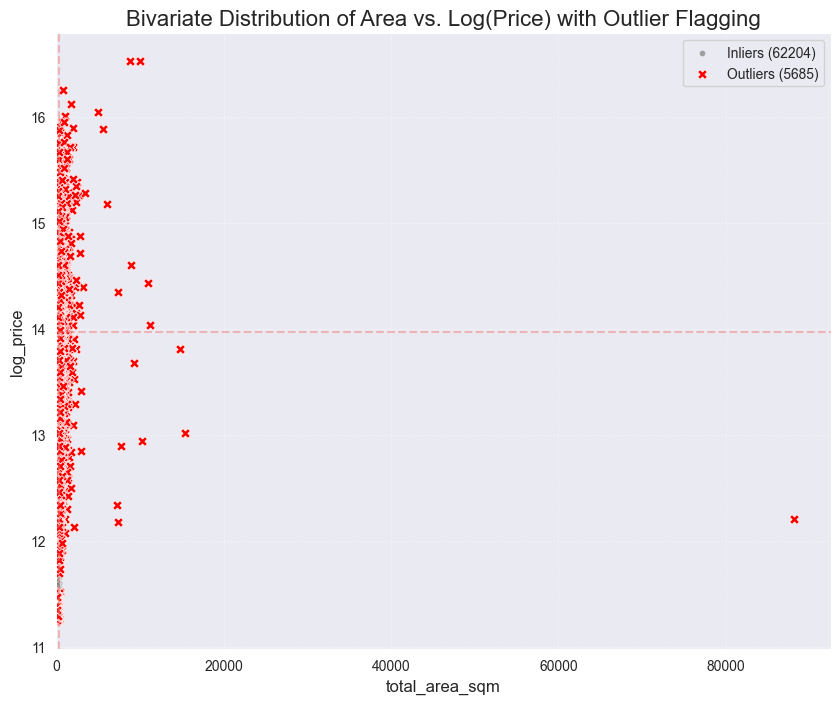

In [8]:
plot_bivariate_outliers(
    log_transformed_price,
    x_col='total_area_sqm',
    y_col='log_price',
    title='Bivariate Distribution of Area vs. Log(Price) with Outlier Flagging'
)